### Loading the data

In [9]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

main_data_path = "/Users/santhoshipriya/Desktop/3rd SEM/ADM/Project/data/data.csv"
artist_data_path = "/Users/santhoshipriya/Desktop/3rd SEM/ADM/Project/data/data_by_artist.csv"

data = pd.read_csv(main_data_path)
artist_data = pd.read_csv(artist_data_path)

 ### Checking for Missing Values

In [12]:
# Checking for missing values in all datasets
print("Missing Values in Main Dataset:")
print(data.isnull().sum())

print("\nMissing Values in Artist Dataset:")
print(artist_data.isnull().sum())


Missing Values in Main Dataset:
valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64

Missing Values in Artist Dataset:
mode                0
count               0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
popularity          0
key                 0
dtype: int64


### Feature Selection

In [15]:
# Define relevant features for the analysis
selected_features  = [
        'acousticness', 'danceability', 'energy', 
        'instrumentalness', 'valence', 'tempo', 'popularity','artists'
]

feature_data = data[selected_features]

feature_data = feature_data.copy()
feature_data['name'] = data['name']

# Display summary statistics
print("Summary Statistics of Selected Features:")
print(feature_data.describe())

Summary Statistics of Selected Features:
        acousticness   danceability         energy  instrumentalness  \
count  170653.000000  170653.000000  170653.000000     170653.000000   
mean        0.502115       0.537396       0.482389          0.167010   
std         0.376032       0.176138       0.267646          0.313475   
min         0.000000       0.000000       0.000000          0.000000   
25%         0.102000       0.415000       0.255000          0.000000   
50%         0.516000       0.548000       0.471000          0.000216   
75%         0.893000       0.668000       0.703000          0.102000   
max         0.996000       0.988000       1.000000          1.000000   

             valence          tempo     popularity  
count  170653.000000  170653.000000  170653.000000  
mean        0.528587     116.861590      31.431794  
std         0.263171      30.708533      21.826615  
min         0.000000       0.000000       0.000000  
25%         0.317000      93.421000      11.0

### Correlation Matrix of Song Features

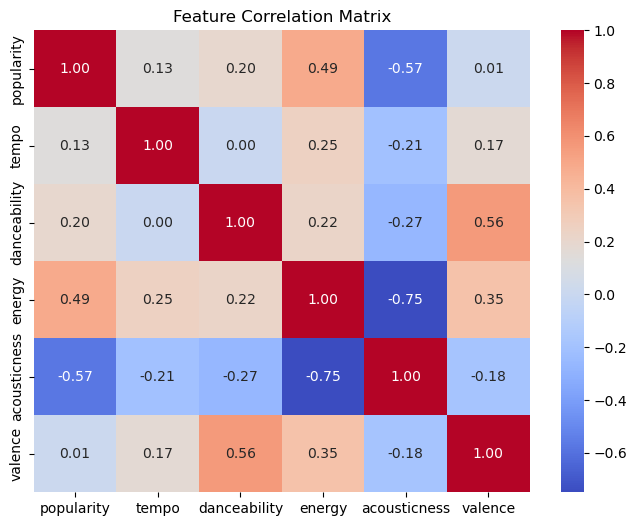

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the features you want to analyze
features_to_normalize = ['popularity', 'tempo', 'danceability', 'energy', 'acousticness', 'valence']

# Compute correlation matrix for these features
corr_matrix = feature_data[features_to_normalize].corr()

# Visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [20]:
feature_data['artists'] = feature_data['artists'].apply(
    lambda x: eval(x)[0] if isinstance(x, str) and x.startswith('[') else x
)

### Data Preprocessing

In [23]:
from sklearn.preprocessing import StandardScaler

# Normalize numerical columns
numerical_cols = feature_data.select_dtypes(include=['float64', 'int64']).columns

# Initialize the scaler
scaler = StandardScaler()

feature_data[numerical_cols] = scaler.fit_transform(feature_data[numerical_cols].copy())

print(feature_data.head())

   acousticness  danceability    energy  instrumentalness   valence     tempo  \
0      1.276187     -1.467013 -1.013988          2.268102 -1.782825 -1.169307   
1      0.611347      1.598779 -0.528270         -0.532771  1.650688 -1.821180   
2      1.220340     -1.188820 -1.182122          2.379754 -1.858821 -0.212404   
3      1.236296     -1.489722 -0.647832         -0.532682 -1.381564 -0.545537   
4      1.209703     -0.677855 -1.081242         -0.532765 -1.047180 -0.494867   

   popularity                                            artists  \
0   -1.256808                                Sergei Rachmaninoff   
1   -1.210993                                         Dennis Day   
2   -1.210993  KHP Kridhamardawa Karaton Ngayogyakarta Hadini...   
3   -1.302624                                       Frank Parker   
4   -1.348440                                         Phil Regan   

                                                name  
0  Piano Concerto No. 3 in D Minor, Op. 30: III. 

### Optimal Clusters Using Elbow Method

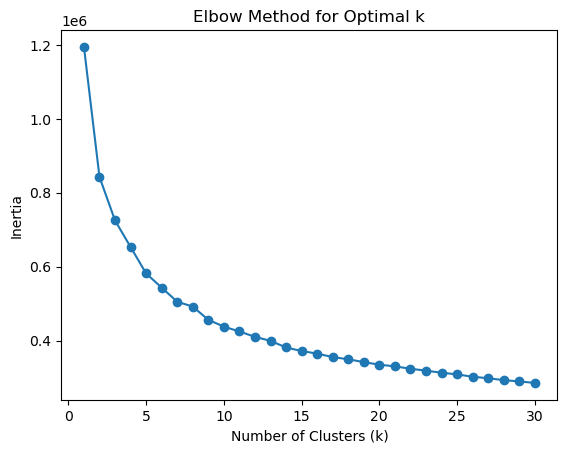

In [26]:
# Calculate inertia for a range of cluster numbers
inertia = []
k_range = range(1, 31)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(feature_data[numerical_cols])
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

### Clustering using K-Means

In [28]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the model and add cluster labels to the data
feature_data['cluster'] = kmeans.fit_predict(feature_data[numerical_cols])

# Display a sample of data with cluster labels
print(feature_data[['name', 'artists', 'cluster']].head())

                                                name  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...   
1                            Clancy Lowered the Boom   
2                                          Gati Bali   
3                                          Danny Boy   
4                        When Irish Eyes Are Smiling   

                                             artists  cluster  
0                                Sergei Rachmaninoff        2  
1                                         Dennis Day        3  
2  KHP Kridhamardawa Karaton Ngayogyakarta Hadini...        2  
3                                       Frank Parker        0  
4                                         Phil Regan        0  


In [29]:
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Calculate the Davies-Bouldin score
db_score = davies_bouldin_score(feature_data[numerical_cols], feature_data['cluster'])
print(f'Davies-Bouldin Score: {db_score}')

# Calculate Silhouette Score for KMeans
sil_score = silhouette_score(feature_data[numerical_cols], feature_data['cluster'])
print(f"Silhouette Score for KMeans: {sil_score}")

Davies-Bouldin Score: 1.5293491261170322
Silhouette Score for KMeans: 0.20999886269550724


### Cluster Visualization

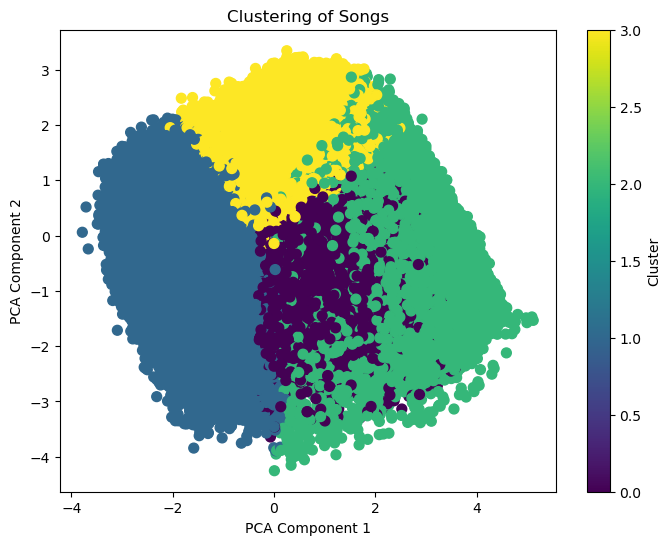

In [31]:
# Use PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_components = pca.fit_transform(feature_data[numerical_cols])

# Create a DataFrame for PCA components and cluster labels
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = feature_data['cluster']

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['cluster'], cmap='viridis', s=50)
plt.title('Clustering of Songs')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

### t-SNE

In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(feature_data[numerical_cols])

# Create a DataFrame for t-SNE components and cluster labels
tsne_df = pd.DataFrame(tsne_components, columns=['TSNE1', 'TSNE2'])
tsne_df['cluster'] = feature_data['cluster']

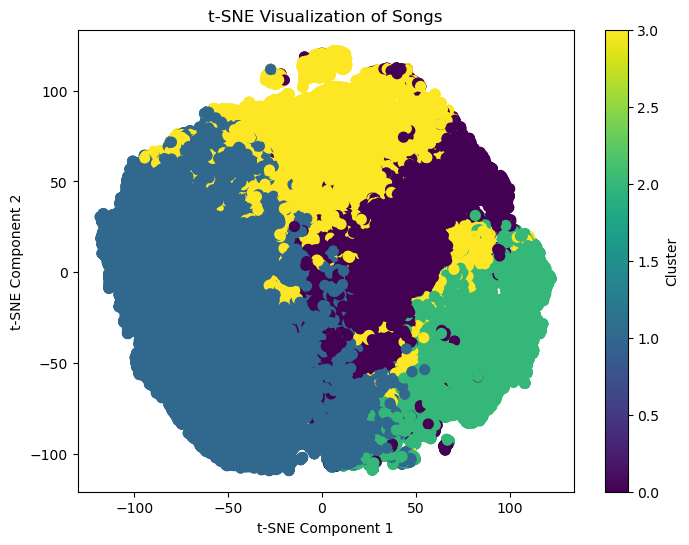

In [36]:
#Plot t-SNE components with cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['cluster'], cmap='viridis', s=50)
plt.title('t-SNE Visualization of Songs')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [37]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

num_clusters = 4

mb_kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=42, batch_size=100)

# Fit the model and add cluster labels to the data
feature_data['cluster'] = mb_kmeans.fit_predict(feature_data[numerical_cols])

# Display a sample of data with cluster labels
print(feature_data[['name', 'artists', 'cluster']].head())

# Calculate the Davies-Bouldin score
db_score = davies_bouldin_score(feature_data[numerical_cols], feature_data['cluster'])
print(f'Davies-Bouldin Score (Mini-Batch K-Means): {db_score}')

# Calculate Silhouette Score for Mini-Batch KMeans
sil_score = silhouette_score(feature_data[numerical_cols], feature_data['cluster'])
print(f"Silhouette Score for Mini-Batch KMeans: {sil_score}")

                                                name  \
0  Piano Concerto No. 3 in D Minor, Op. 30: III. ...   
1                            Clancy Lowered the Boom   
2                                          Gati Bali   
3                                          Danny Boy   
4                        When Irish Eyes Are Smiling   

                                             artists  cluster  
0                                Sergei Rachmaninoff        0  
1                                         Dennis Day        2  
2  KHP Kridhamardawa Karaton Ngayogyakarta Hadini...        0  
3                                       Frank Parker        0  
4                                         Phil Regan        0  
Davies-Bouldin Score (Mini-Batch K-Means): 1.5156664241951083
Silhouette Score for Mini-Batch KMeans: 0.2104579548607184


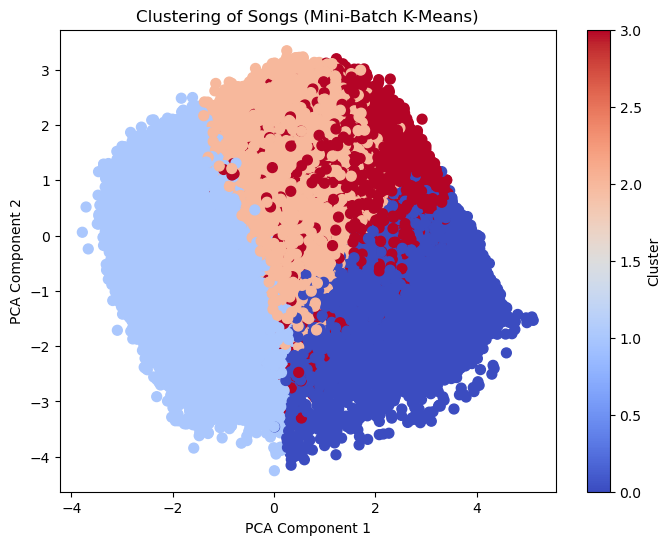

In [38]:
# Use PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_components = pca.fit_transform(feature_data[numerical_cols])

# Create a DataFrame for PCA components and cluster labels
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = feature_data['cluster']

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['cluster'], cmap='coolwarm', s=50)
plt.title('Clustering of Songs (Mini-Batch K-Means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

### Recommendation System

In [40]:
# Function to recommend songs based on artist and cluster
def recommend_songs_by_artist_and_cluster(song_name, feature_data, kmeans_model, num_recommendations=5):
    try:
        song_artist = feature_data[feature_data['name'] == song_name]['artists'].values[0]
        song_cluster = feature_data[feature_data['name'] == song_name]['cluster'].values[0]
        
        # Filter the songs from the same cluster and same artist
        recommended_songs = feature_data[(feature_data['cluster'] == song_cluster) & (feature_data['artists'] == song_artist)]
        
        recommended_songs = recommended_songs[recommended_songs['name'] != song_name]
        
        top_recommended = recommended_songs.head(num_recommendations)
        return top_recommended[['name', 'artists', 'cluster']]
    
    except IndexError:
        print(f"Error: The song '{song_name}' was not found in the dataset.")
        return None

song_name = input("Enter the name of the song to get recommendations: ")

recommendations = recommend_songs_by_artist_and_cluster(song_name, feature_data, kmeans)

if recommendations is not None and not recommendations.empty:
    print("\nRecommended Songs based on Artist and Cluster:")
    print(recommendations)
else:
    print("\nNo recommendations available for the given song.")


Enter the name of the song to get recommendations:  Valentines Day



Recommended Songs based on Artist and Cluster:
                                                    name     artists  cluster
3962                               Mig Fångar Ingen Brud  Local Oafs        1
22981                               Sämsta Ligget I Stan  Local Oafs        1
23062                                       Dead by Dawn  Local Oafs        1
41446  The Best Thing That Ever Happend to Me (Is Not...  Local Oafs        1
41522                                      Back in Style  Local Oafs        1


### Recommendation System Based on Genres

In [42]:
data_by_genres = pd.read_csv("/Users/santhoshipriya/Desktop/3rd SEM/ADM/Project/data/data_by_genres.csv")
# User-defined function to identify genre based on song name
def identify_genre_by_name(selected_song):
    song_data = data[data['name'].str.lower() == selected_song.lower()]
    
    if song_data.empty:
        return f"No data available for the song: {selected_song}"
        
    artist_name = song_data.iloc[0]['artists']
    
    song_acousticness = song_data.iloc[0]['acousticness']
    song_tempo = song_data.iloc[0]['tempo']
    
    # Match songs based on common features: acousticness and tempo
    genre_data = data_by_genres[
        (data_by_genres['acousticness'] >= song_acousticness - 0.1) &
        (data_by_genres['acousticness'] <= song_acousticness + 0.1) &
        (data_by_genres['tempo'] >= song_tempo - 10) &
        (data_by_genres['tempo'] <= song_tempo + 10)
    ]
    
    if genre_data.empty:
        return f"No genre data available for the song: {selected_song}"
    selected_genre = genre_data.iloc[0]['genres']
    return selected_genre

def recommend_songs_by_genre(selected_genre, top_n=10):
    genre_data = data_by_genres[data_by_genres['genres'] == selected_genre]
    
    if genre_data.empty:
        return f"No data available for the genre: {selected_genre}"

    top_genre_songs = genre_data.sort_values(by='popularity', ascending=False).head(top_n)

    recommendations = []
    for _, row in top_genre_songs.iterrows():
        matching_songs = data[(data['acousticness'] >= row['acousticness'] - 0.1) &
                              (data['acousticness'] <= row['acousticness'] + 0.1) &
                              (data['tempo'] >= row['tempo'] - 10) &
                              (data['tempo'] <= row['tempo'] + 10)]
        for _, song in matching_songs.iterrows():
            recommendations.append({
                'Song': song['name'],
                'Artist': song['artists'],
                'Genre': selected_genre,
                'Popularity': song['popularity']
            })
    
    recommendations_df = pd.DataFrame(recommendations).sort_values(by='Popularity', ascending=False)
    return recommendations_df.head(top_n)

selected_song = input("Enter a song name:").strip()

selected_genre = identify_genre_by_name(selected_song)

if "No data available" not in selected_genre:
    recommended_songs = recommend_songs_by_genre(selected_genre, top_n=10)
    if isinstance(recommended_songs, pd.DataFrame) and not recommended_songs.empty:
        print(f"\nTop {len(recommended_songs)} song recommendations for the genre of '{selected_song}':")
        print(recommended_songs.to_string(index=False))
    else:
        print(recommended_songs)
else:
    print(selected_genre)

Enter a song name: Diamonds



Top 10 song recommendations for the genre of 'Diamonds':
                                  Song                               Artist             Genre  Popularity
                   Put Your Records On                      ['Ritt Momney'] asbury park indie          93
                             La Tóxica                          ['Farruko'] asbury park indie          92
                                 Jeans                    ['Justin Quiles'] asbury park indie          91
            Tattoo - Remix with Camilo         ['Rauw Alejandro', 'Camilo'] asbury park indie          90
                          Life Goes On                              ['BTS'] asbury park indie          90
Be Like That - feat. Swae Lee & Khalid ['Kane Brown', 'Swae Lee', 'Khalid'] asbury park indie          87
                                  Azul                         ['J Balvin'] asbury park indie          87
                  GREECE (feat. Drake)               ['DJ Khaled', 'Drake'] asbury park indie 